In [1]:
%matplotlib inline
import logging

import os
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from glob import glob
import wandb

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, RandomCrop

from tqdm import tqdm
from sklearn.manifold import TSNE
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


import torchvision
import umap
from cycler import cycler

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.1.2


In [2]:
import wandb
wandb.login(key="c2495856d9d06f4cad1ad47b0f49bfef71560762")

wandb: Currently logged in as: xiaomeng9061. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/mxiao/.netrc


True

In [12]:
wandb.init(project = 'comic-classification',
           save_code = True)

In [2]:
path = '/var/scratch/mxiao/data/'
os.chdir(path)

In [6]:
!ls PML_v3

classifier_38.pth		 embedder_optimizer_best36.pth
classifier_best36.pth		 metric_loss_38.pth
classifier_loss_38.pth		 metric_loss_best36.pth
classifier_loss_best36.pth	 trunk_38.pth
classifier_optimizer_38.pth	 trunk_best36.pth
classifier_optimizer_best36.pth  trunk_optimizer_38.pth
embedder_38.pth			 trunk_optimizer_best36.pth
embedder_best36.pth		 tuple_miner_38.pth
embedder_optimizer_38.pth	 tuple_miner_best36.pth


In [3]:
!ls example_logs

accuracies_normalized_GlobalEmbeddingSpaceTester_level_0_VAL_vs_self.csv
classifier_optimizer_Adam.csv
embedder_optimizer_Adam.csv
logs.db
loss_histories.csv
loss_weights.csv
metric_loss_TripletMarginLoss.csv
metric_loss_TripletMarginLoss__modules_distance_LpDistance.csv
metric_loss_TripletMarginLoss__modules_reducer_AvgNonZeroReducer.csv
trunk_optimizer_Adam.csv
tuple_miner_MultiSimilarityMiner.csv


In [53]:
df = pd.read_csv('example_logs/accuracies_normalized_GlobalEmbeddingSpaceTester_level_0_VAL_vs_self.csv')
df

~iteration~  epoch  AMI_level0  NMI_level0  mean_average_precision_level0  \
0             1      1    0.351984    0.670501                       0.152761   
1             2      2    0.418499    0.704553                       0.208462   
2             3      3    0.463759    0.727740                       0.247623   
3             4      4    0.504120    0.748130                       0.282741   
4             5      5    0.524899    0.758209                       0.304294   
5             6      6    0.542774    0.767502                       0.317495   
6             7      7    0.561082    0.776805                       0.332756   
7             8      8    0.565795    0.779077                       0.342536   
8             9      9    0.579987    0.786056                       0.351085   
9            10     10    0.585175    0.789040                       0.358323   
10           11     11    0.593733    0.793337                       0.369637   
11           12     12    0.610933    0.801625                       0.384531   
12           13     13    0.611881    0.802336                       0.381584   
13           14     14    0.608734    0.800851                       0.390403   
14           15     15    0.624606    0.808891                       0.398727   
15           16     16    0.621701    0.807430                       0.401950   
16           17     17    0.629702    0.811209                       0.407685   
17           18     18    0.636263    0.814210                       0.411043   
18           19     19    0.643502    0.818149                       0.422597   
19           20     20    0.641140    0.817137                       0.421762   
20           21     21    0.651490    0.822534                       0.428613   
21           22     22    0.648929    0.821143                       0.427293   
22           23     23    0.652756    0.822953                       0.428282   

    mean_average_precision_at_r_level0  mean_reciprocal_rank_level0  \
0                             0.123973                     0.547345   
1                             0.170819                     0.624369   
2                             0.205620                     0.673571   
3                             0.236430                     0.708053   
4                             0.255380                     0.731418   
5                             0.267845                     0.747270   
6                             0.281142                     0.761845   
7                             0.290896                     0.769163   
8                             0.297762                     0.778594   
9                             0.304173                     0.783253   
10                            0.315078                     0.792257   
11                            0.328257                     0.802673   
12                            0.325741                     0.802554   
13                            0.333383                     0.809895   
14                            0.340007                     0.813409   
15                            0.343450                     0.815139   
16                            0.349305                     0.820305   
17                            0.352431                     0.820868   
18                            0.362597                     0.825249   
19                            0.361205                     0.831721   
20                            0.366939                     0.832468   
21                            0.366196                     0.832985   
22                            0.366512                     0.830006   

    precision_at_1_level0  r_precision_level0  best_epoch  best_accuracy  
0                0.442613            0.202258           1       0.123973  
1                0.524754            0.255803           2       0.170819  
2                0.582614            0.291297           3       0.205620  
3                0.623100            0.322305         

In [58]:
table = wandb.Table(dataframe=df)

In [59]:
wandb.log({"csv_data": table})

In [17]:
!ls PML_v3

classifier_38.pth		 embedder_optimizer_best36.pth
classifier_best36.pth		 metric_loss_38.pth
classifier_loss_38.pth		 metric_loss_best36.pth
classifier_loss_best36.pth	 trunk_38.pth
classifier_optimizer_38.pth	 trunk_best36.pth
classifier_optimizer_best36.pth  trunk_optimizer_38.pth
embedder_38.pth			 trunk_optimizer_best36.pth
embedder_best36.pth		 tuple_miner_38.pth
embedder_optimizer_38.pth	 tuple_miner_best36.pth


In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
# Set the image transforms
# normalize = transforms.Normalize(mean=[0.6195012,0.6195012,0.6195012], std=[0.3307451,0.3307451,0.3307451])
normalize = transforms.Normalize(mean=[0.53997546,0.53997546,0.53997546], std=[0.36844322,0.36844322,0.36844322])

train_transform = transforms.Compose([
#         transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.Resize(224),             # resize shortest side to 224 pixels
#         transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.RandomCrop(size=(224,224),pad_if_needed=True), 
        transforms.ToTensor(),
        normalize
    ])

test_transform = transforms.Compose([
        transforms.RandomCrop((224,224),pad_if_needed=True),
        transforms.ToTensor(),
        normalize
    ])

In [6]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Resnet
# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet101(pretrained=True).to(device)
trunk_output_size = trunk.fc.in_features
trunk.fc = nn.Identity()

In [37]:
trunk_output_size

1280

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 1024]).to(device))

# We'll specify the classification loss further down in the code.
classifier = torch.nn.DataParallel(MLP([1024, len(class_dict)])).to(device)

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.0001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(
    embedder.parameters(), lr=0.0001, weight_decay=0.0001
)
classifier_optimizer = torch.optim.Adam(
    classifier.parameters(), lr=0.0001, weight_decay=0.0001
)

In [10]:
models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}
models

{'trunk': DataParallel(
   (module): EfficientNet(
     (_conv_stem): Conv2dStaticSamePadding(
       3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
       (static_padding): ZeroPad2d((0, 1, 0, 1))
     )
     (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
     (_blocks): ModuleList(
       (0): MBConvBlock(
         (_depthwise_conv): Conv2dStaticSamePadding(
           32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
           (static_padding): ZeroPad2d((1, 1, 1, 1))
         )
         (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
         (_se_reduce): Conv2dStaticSamePadding(
           32, 8, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_se_expand): Conv2dStaticSamePadding(
           8, 32, kernel_size=(1, 1), stride=(1, 1)
           (static_padding): Identity()
         )
         (_projec

In [14]:
# train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the classification loss:
classification_loss = torch.nn.CrossEntropyLoss()

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# miner = miners.TripletMarginMiner(
#     margin=0.2, distance=distance, type_of_triplets="hard"
# )

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    dataset1.targets, m=4, length_before_new_iter=len(dataset1)
)

# Set other training parameters
num_epochs = 40

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}
optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
    "classifier_optimizer": classifier_optimizer,
}
loss_funcs = {"metric_loss": loss, "classifier_loss": classification_loss}
mining_funcs = {"tuple_miner": miner}

# We can specify loss weights if we want to. This is optional
loss_weights = {"metric_loss": 1, "classifier_loss": 0.5}

In [12]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs_res101_0001lr", "example_tensorboard_res101_0001lr"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": dataset2}
model_folder = "PML_v6"
#v3:resnet50-no_augmentation
#v4:resnet50-augmentation
#v5:efficientnet b0-no augmentation
#v6:resnet101-no_augmentation 0.0001lr

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()


# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=4,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=1
)

In [13]:
trainer = trainers.TrainWithClassifier(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    dataset1,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=4,
    loss_weights=loss_weights,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

In [21]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir example_tensorboard
# %tensorboard --logdir=./logs --host localhost

Reusing TensorBoard on port 6006 (pid 3142), started 0:02:48 ago. (Use '!kill 3142' to kill it.)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=2.49693: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:45<00:00,  1.76it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.80it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


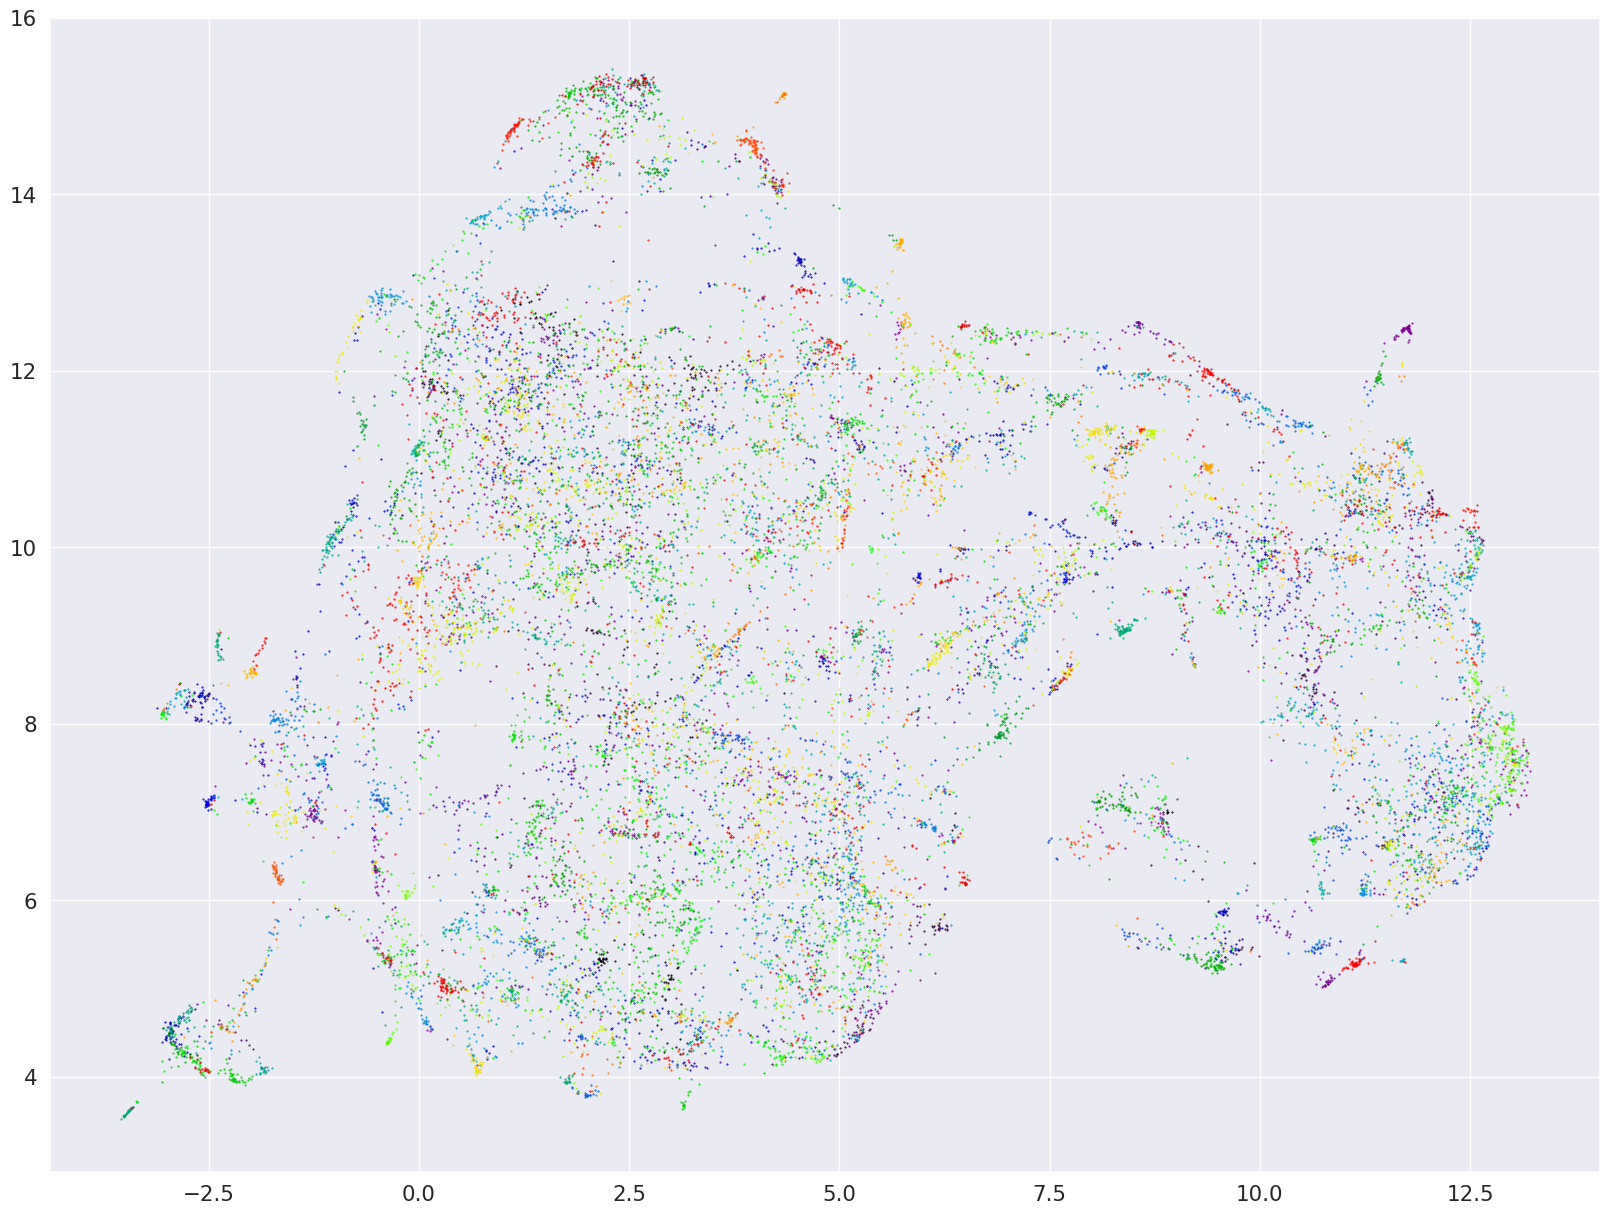

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.17703873369647058
INFO:PML:TRAINING EPOCH 2
total_loss=1.89803: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:51<00:00,  1.74it/s]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:38<00:00,  5.72it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


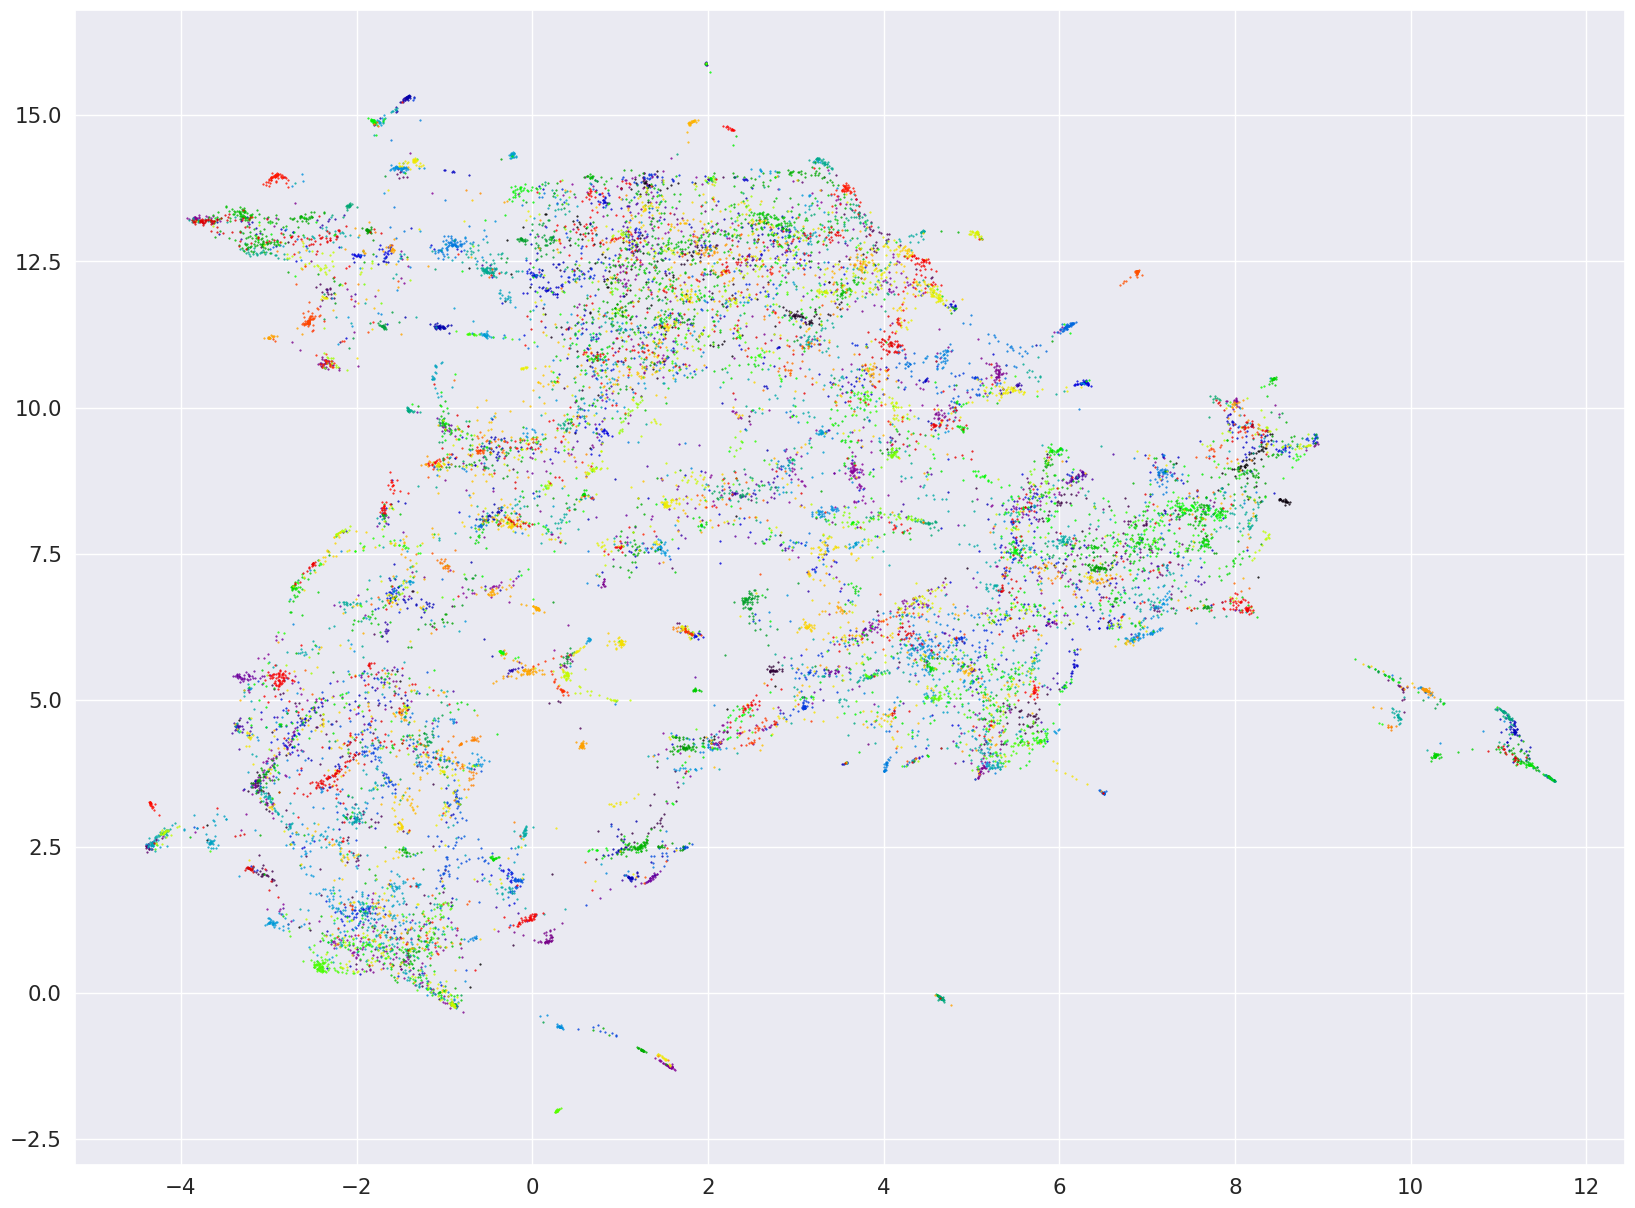

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.24341100535930552
INFO:PML:TRAINING EPOCH 3
total_loss=2.07892: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:48<00:00,  1.75it/s]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.86it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


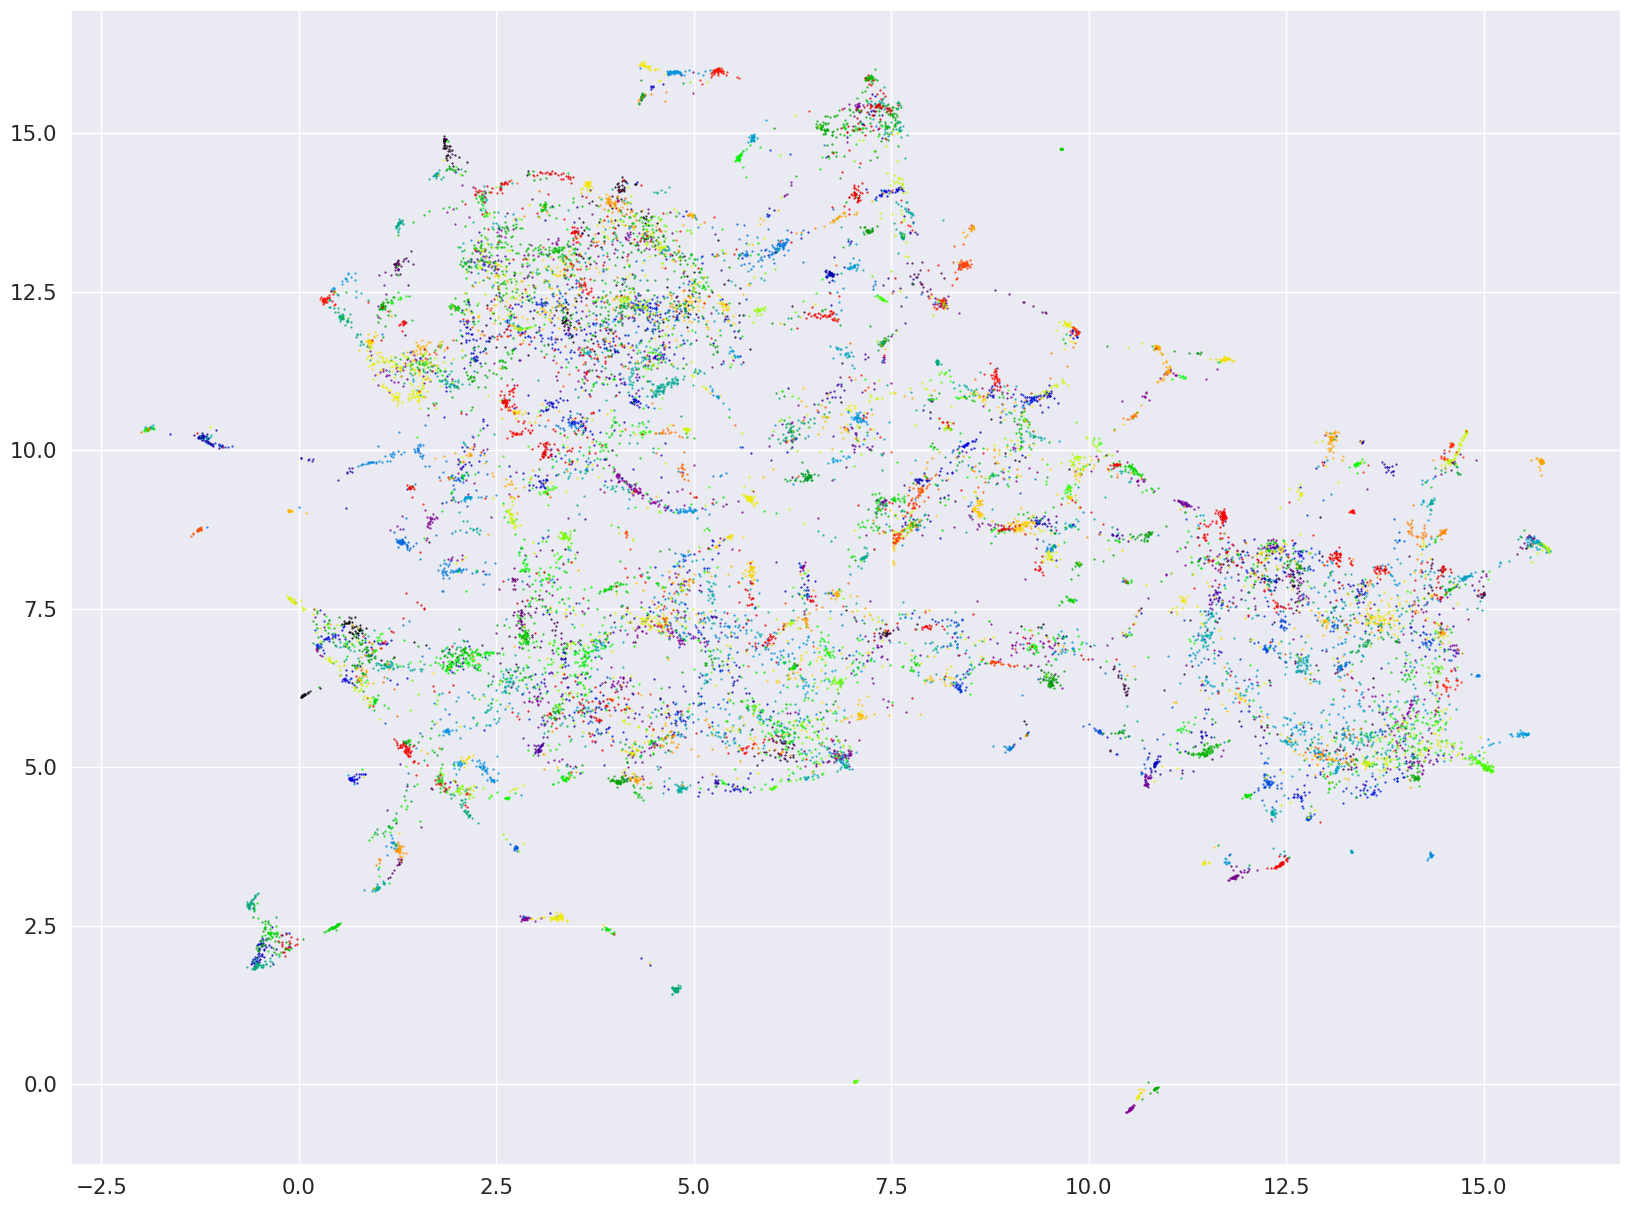

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.28314303650694556
INFO:PML:TRAINING EPOCH 4
total_loss=1.55122: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:47<00:00,  1.75it/s]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.82it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


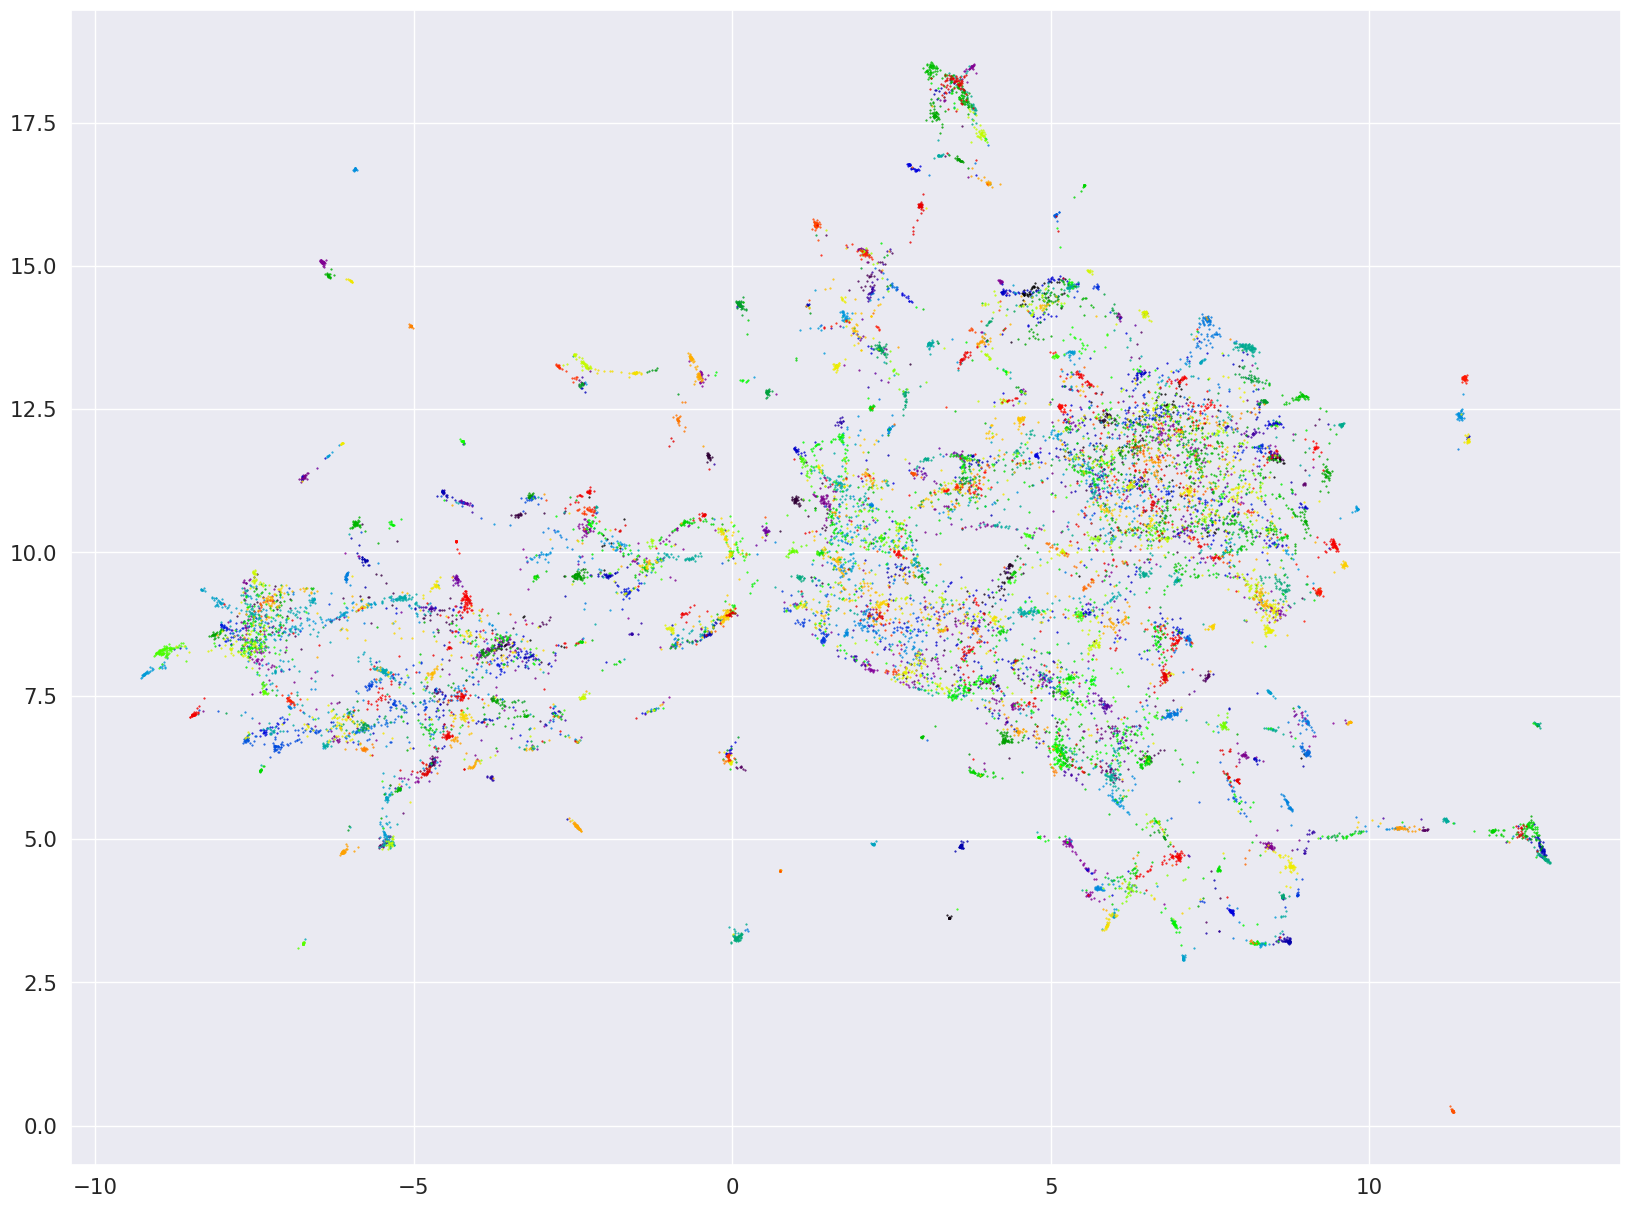

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.32924317421625593
INFO:PML:TRAINING EPOCH 5
total_loss=1.23212: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:55<00:00,  1.73it/s]
INFO:PML:Evaluating epoch 5
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.83it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


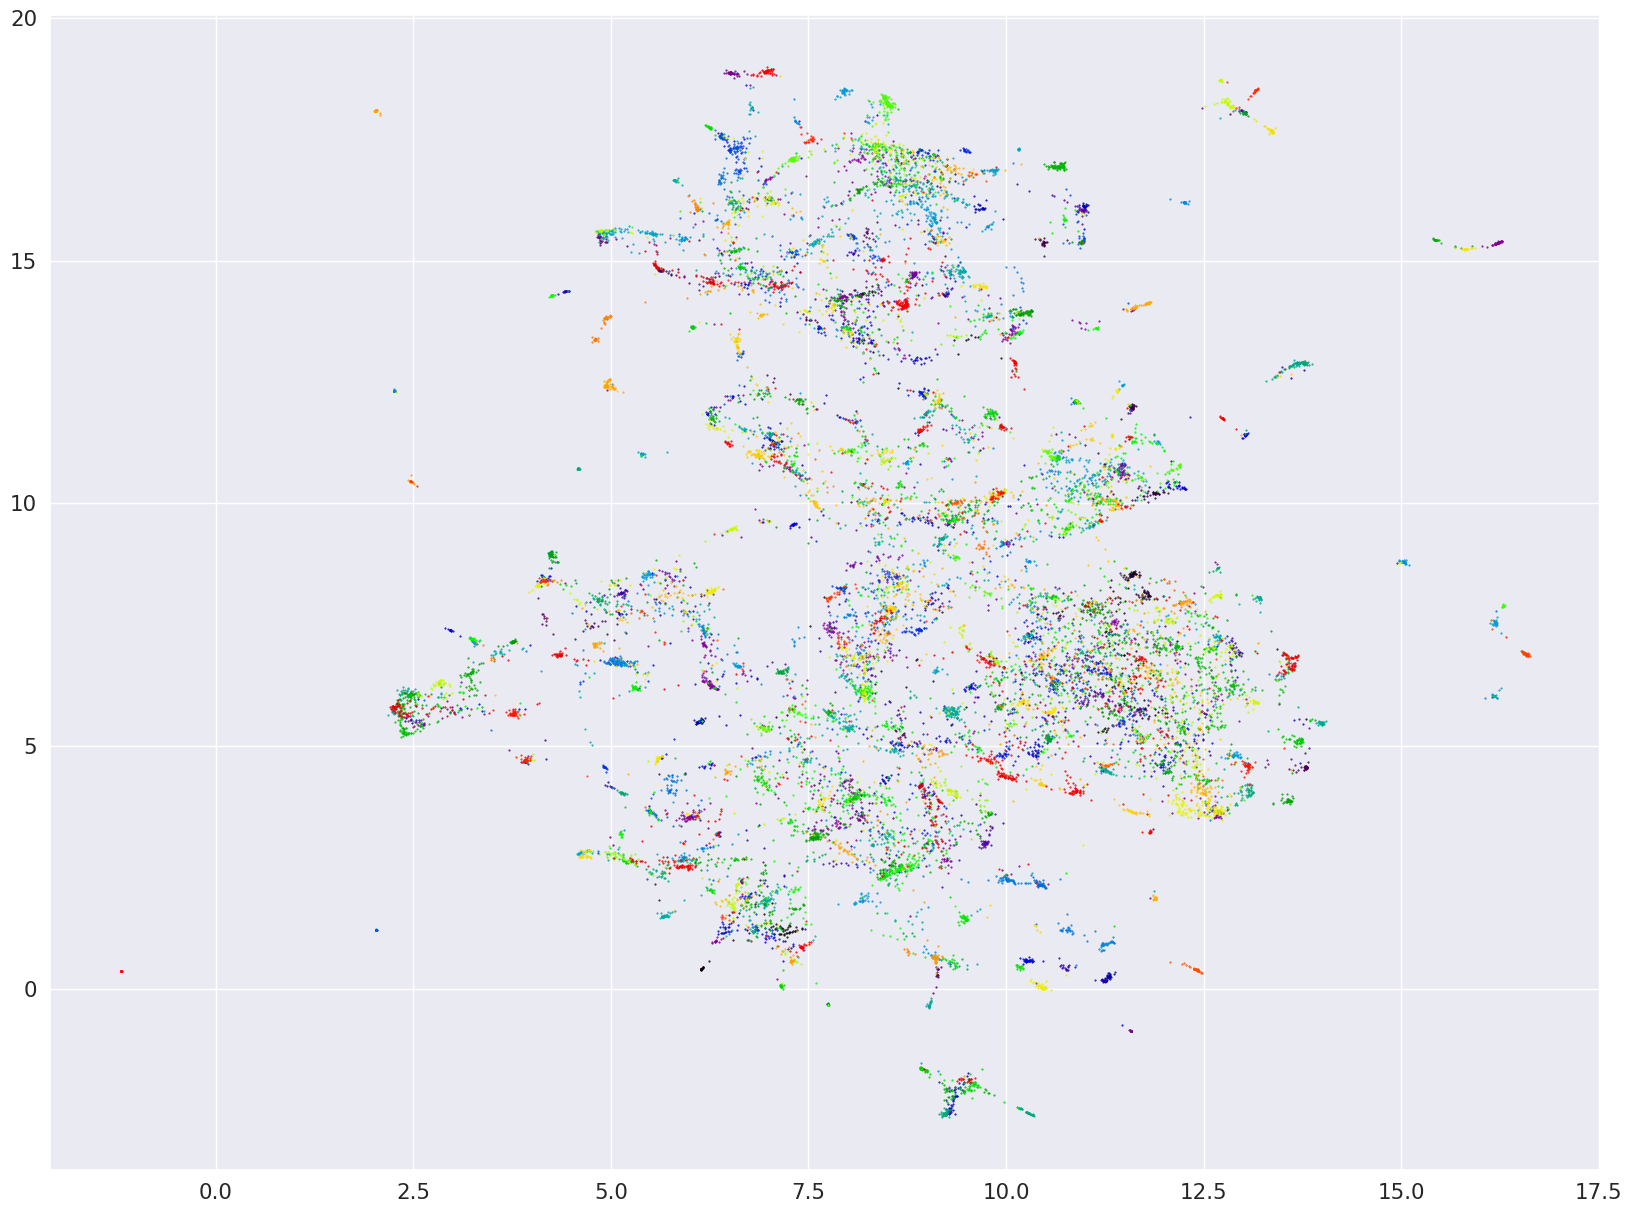

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:TRAINING EPOCH 6
total_loss=1.48211: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:51<00:00,  1.74it/s]
INFO:PML:Evaluating epoch 6
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.84it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


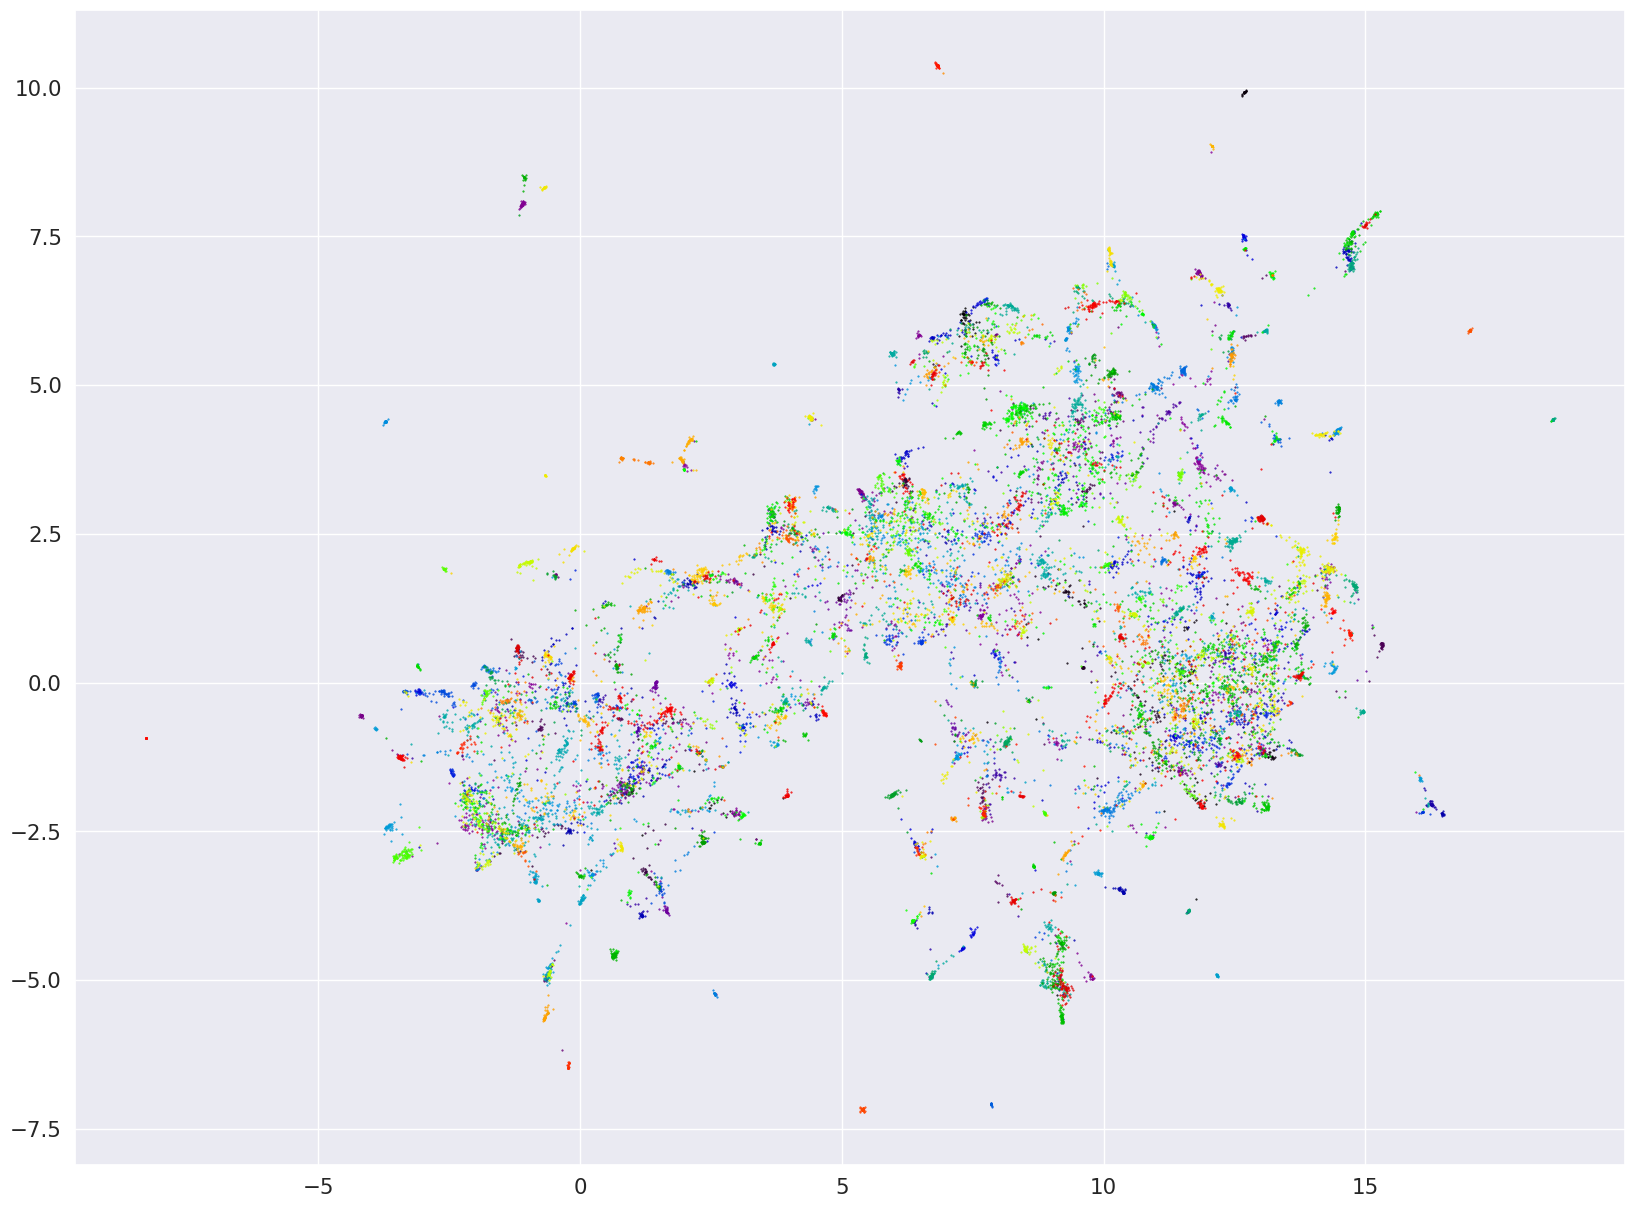

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.34435376909010007
INFO:PML:TRAINING EPOCH 7
total_loss=1.03159: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:51<00:00,  1.74it/s]
INFO:PML:Evaluating epoch 7
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:35<00:00,  5.87it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


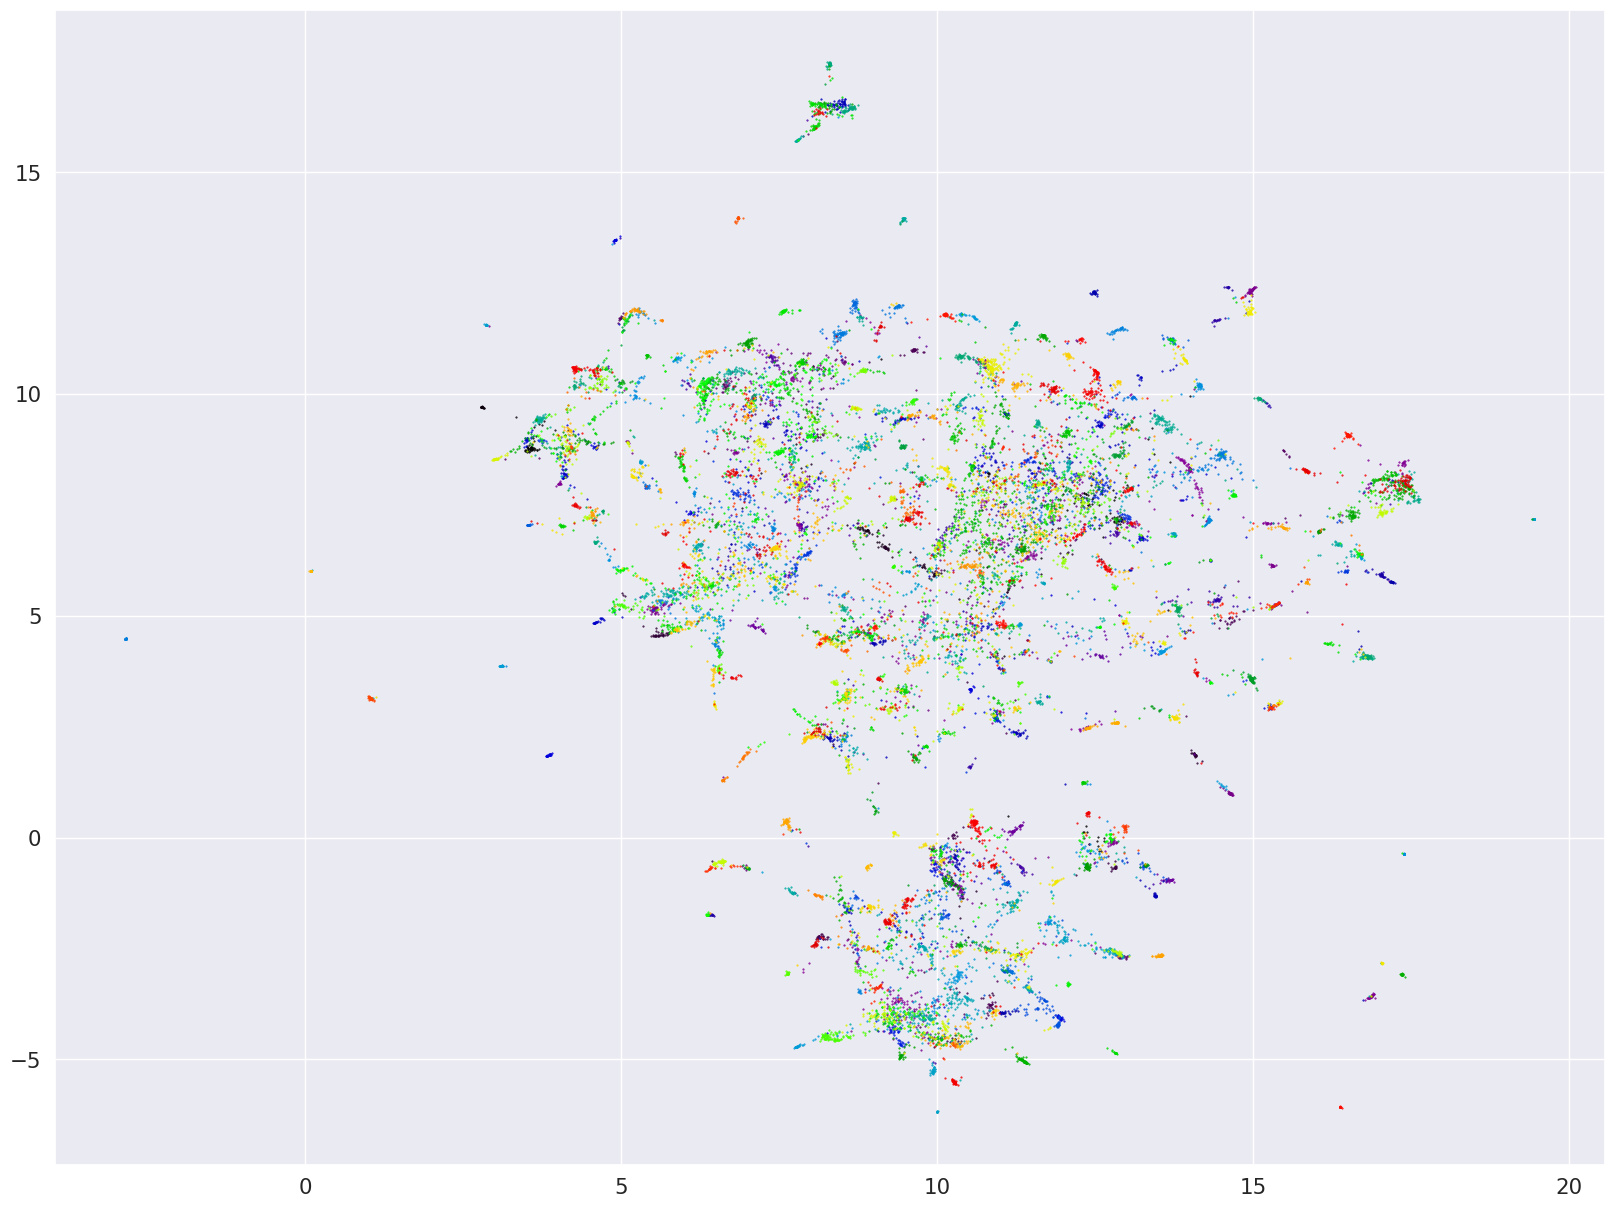

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.35542503268994124
INFO:PML:TRAINING EPOCH 8
total_loss=0.94470: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:57<00:00,  1.72it/s]
INFO:PML:Evaluating epoch 8
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.81it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


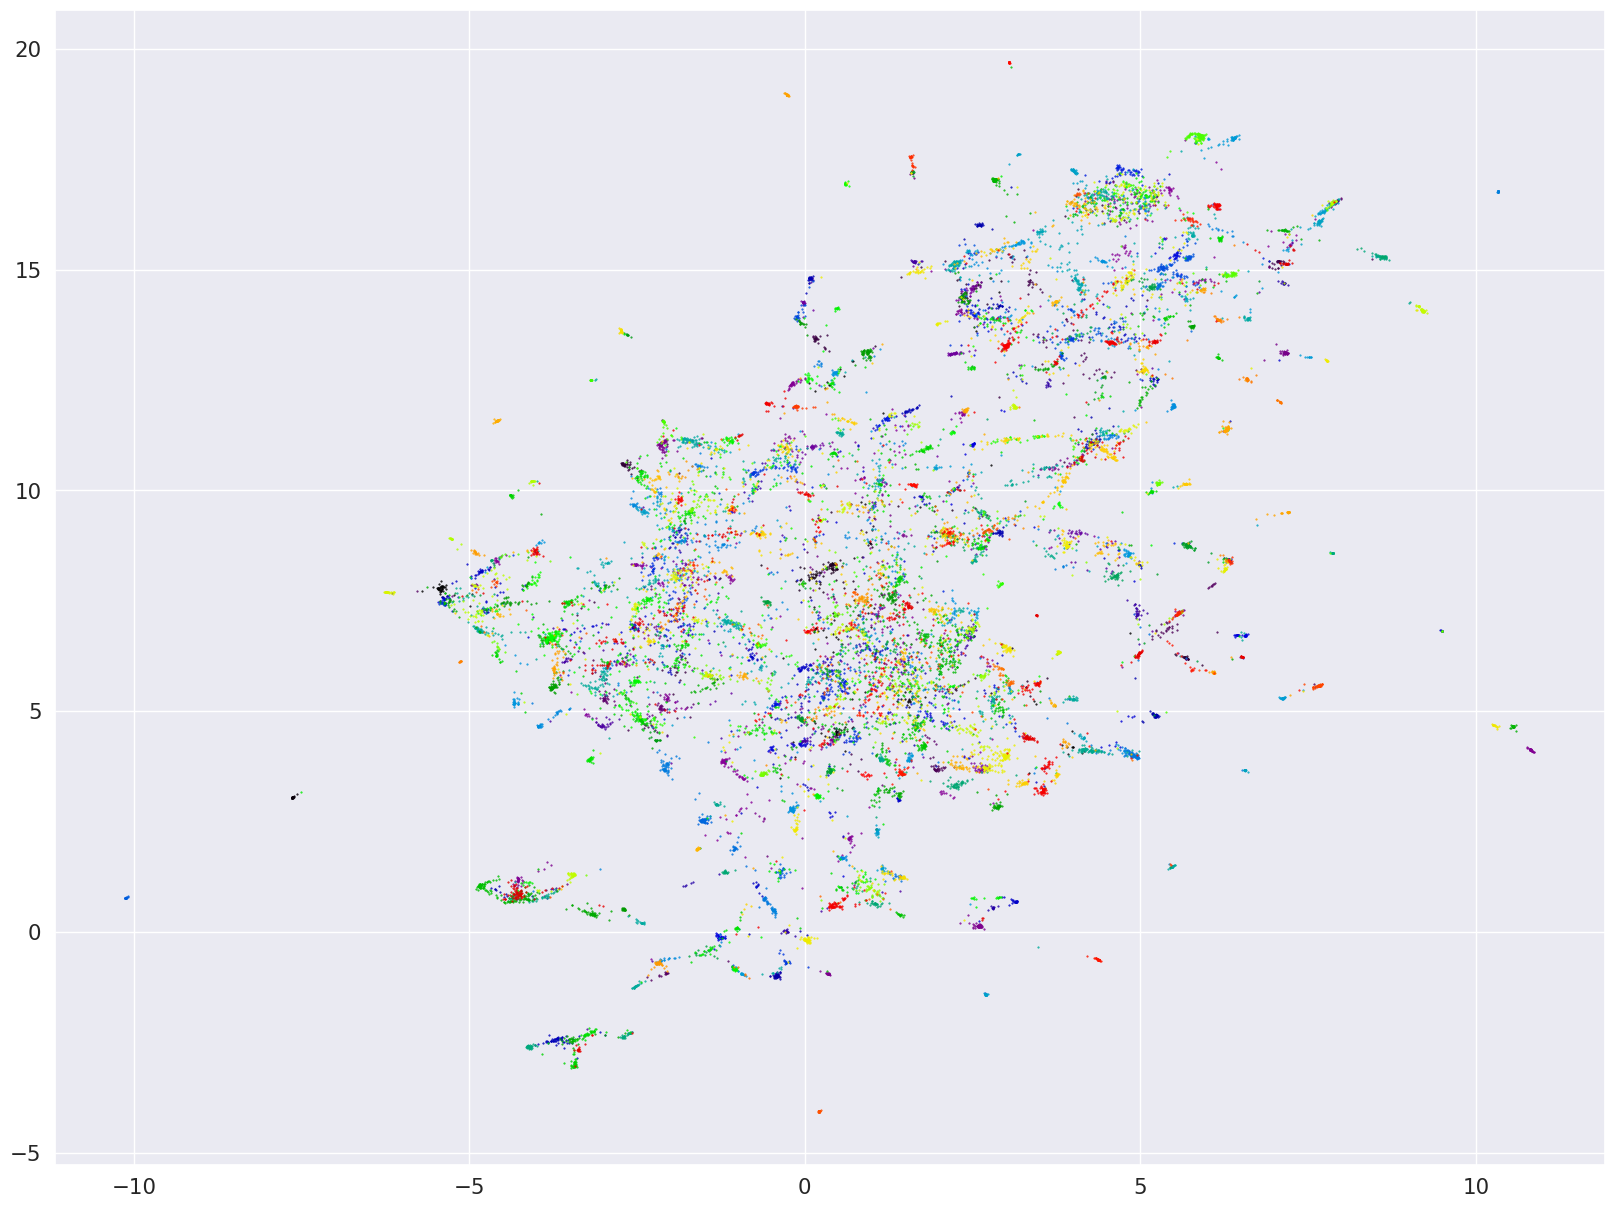

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3681121566206482
INFO:PML:TRAINING EPOCH 9
total_loss=0.80848: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:56<00:00,  1.72it/s]
INFO:PML:Evaluating epoch 9
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.81it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


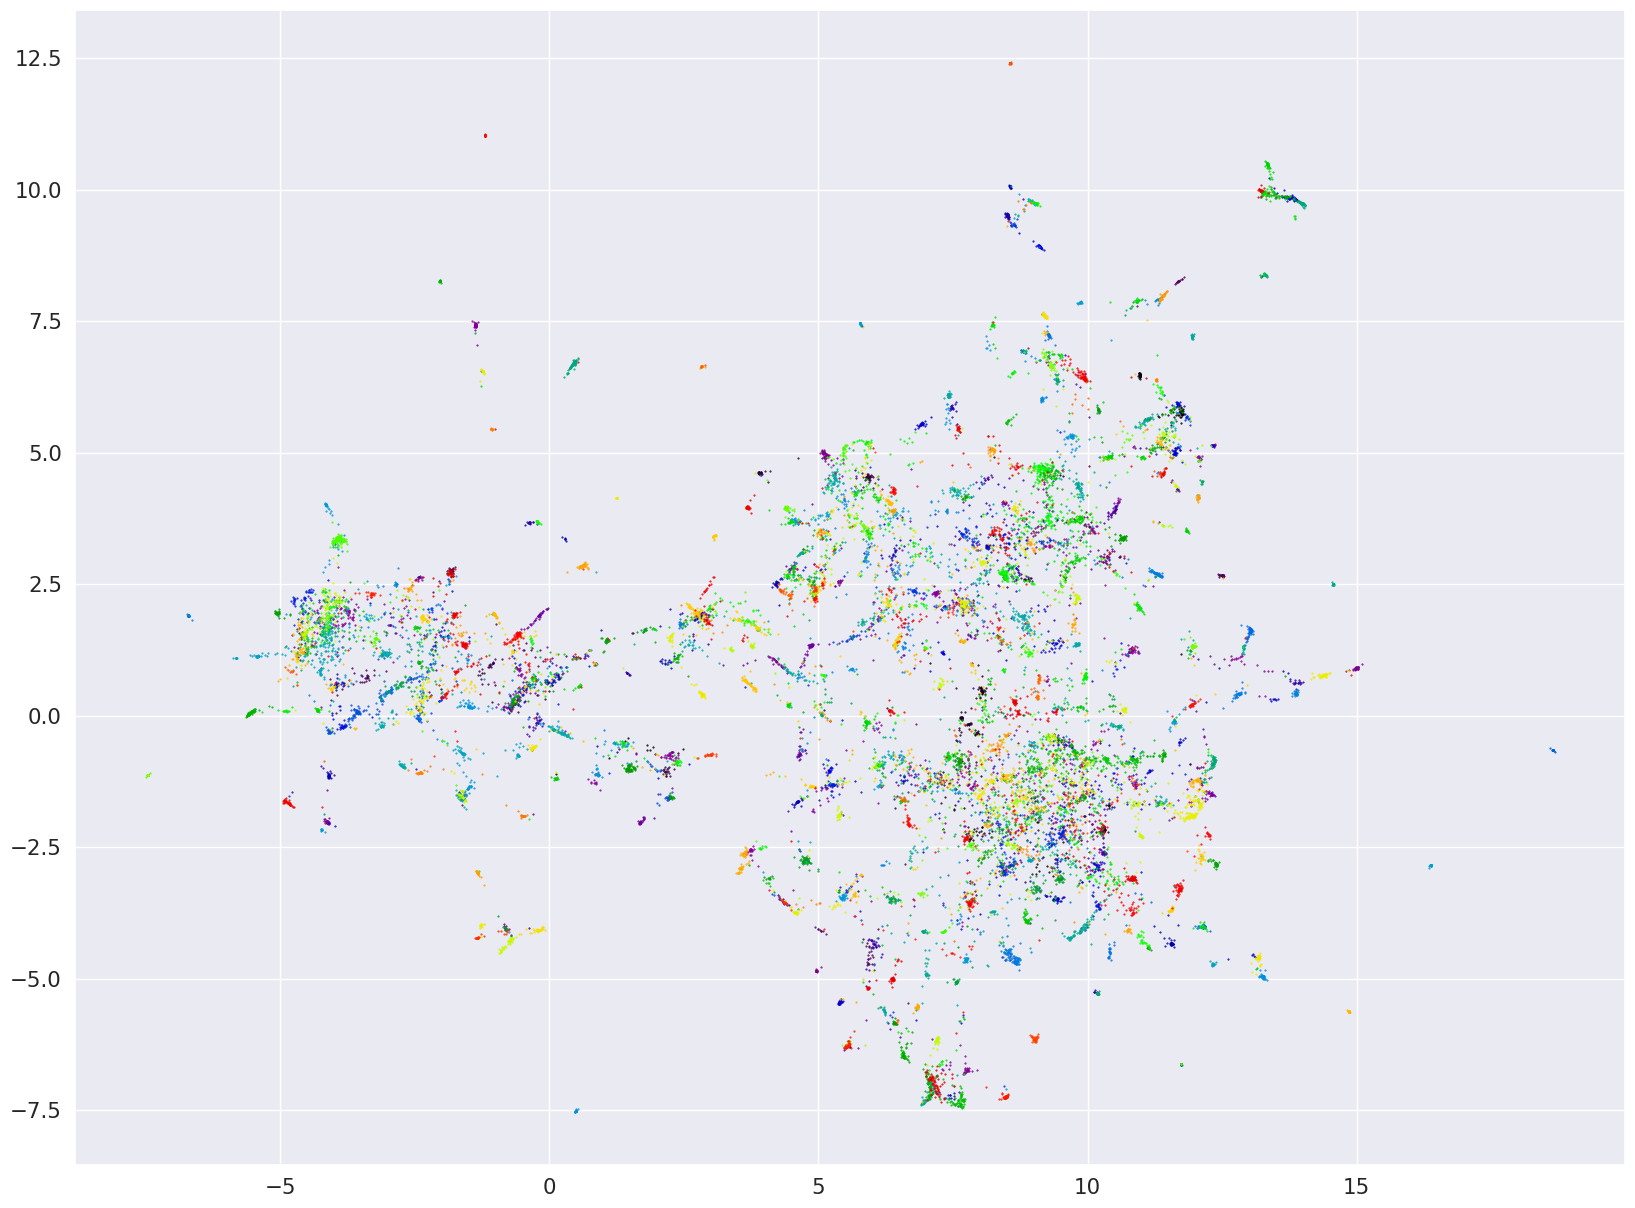

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3870006982308876
INFO:PML:TRAINING EPOCH 10
total_loss=0.67975: 100%|███████████████████████████████████████████████████████████| 1028/1028 [09:54<00:00,  1.73it/s]
INFO:PML:Evaluating epoch 10
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:38<00:00,  5.69it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


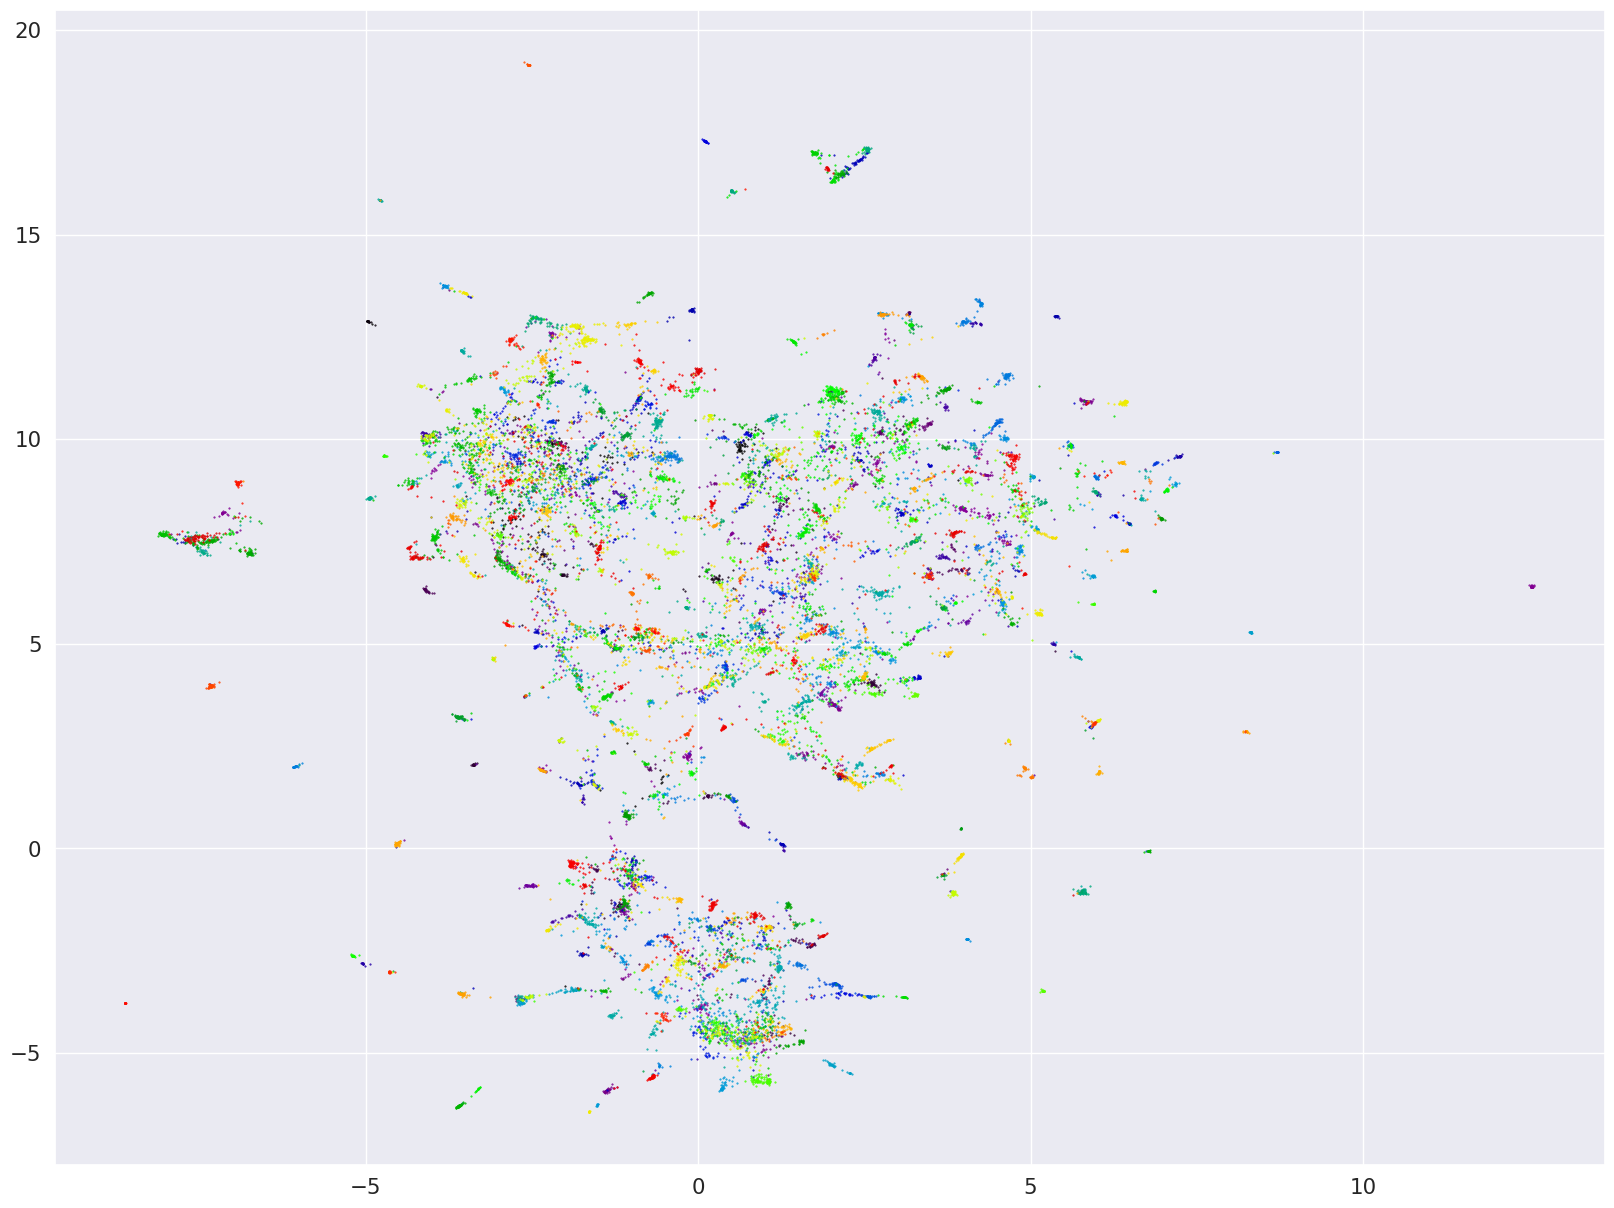

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:TRAINING EPOCH 11
total_loss=0.78706: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:09<00:00,  1.69it/s]
INFO:PML:Evaluating epoch 11
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:37<00:00,  5.77it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


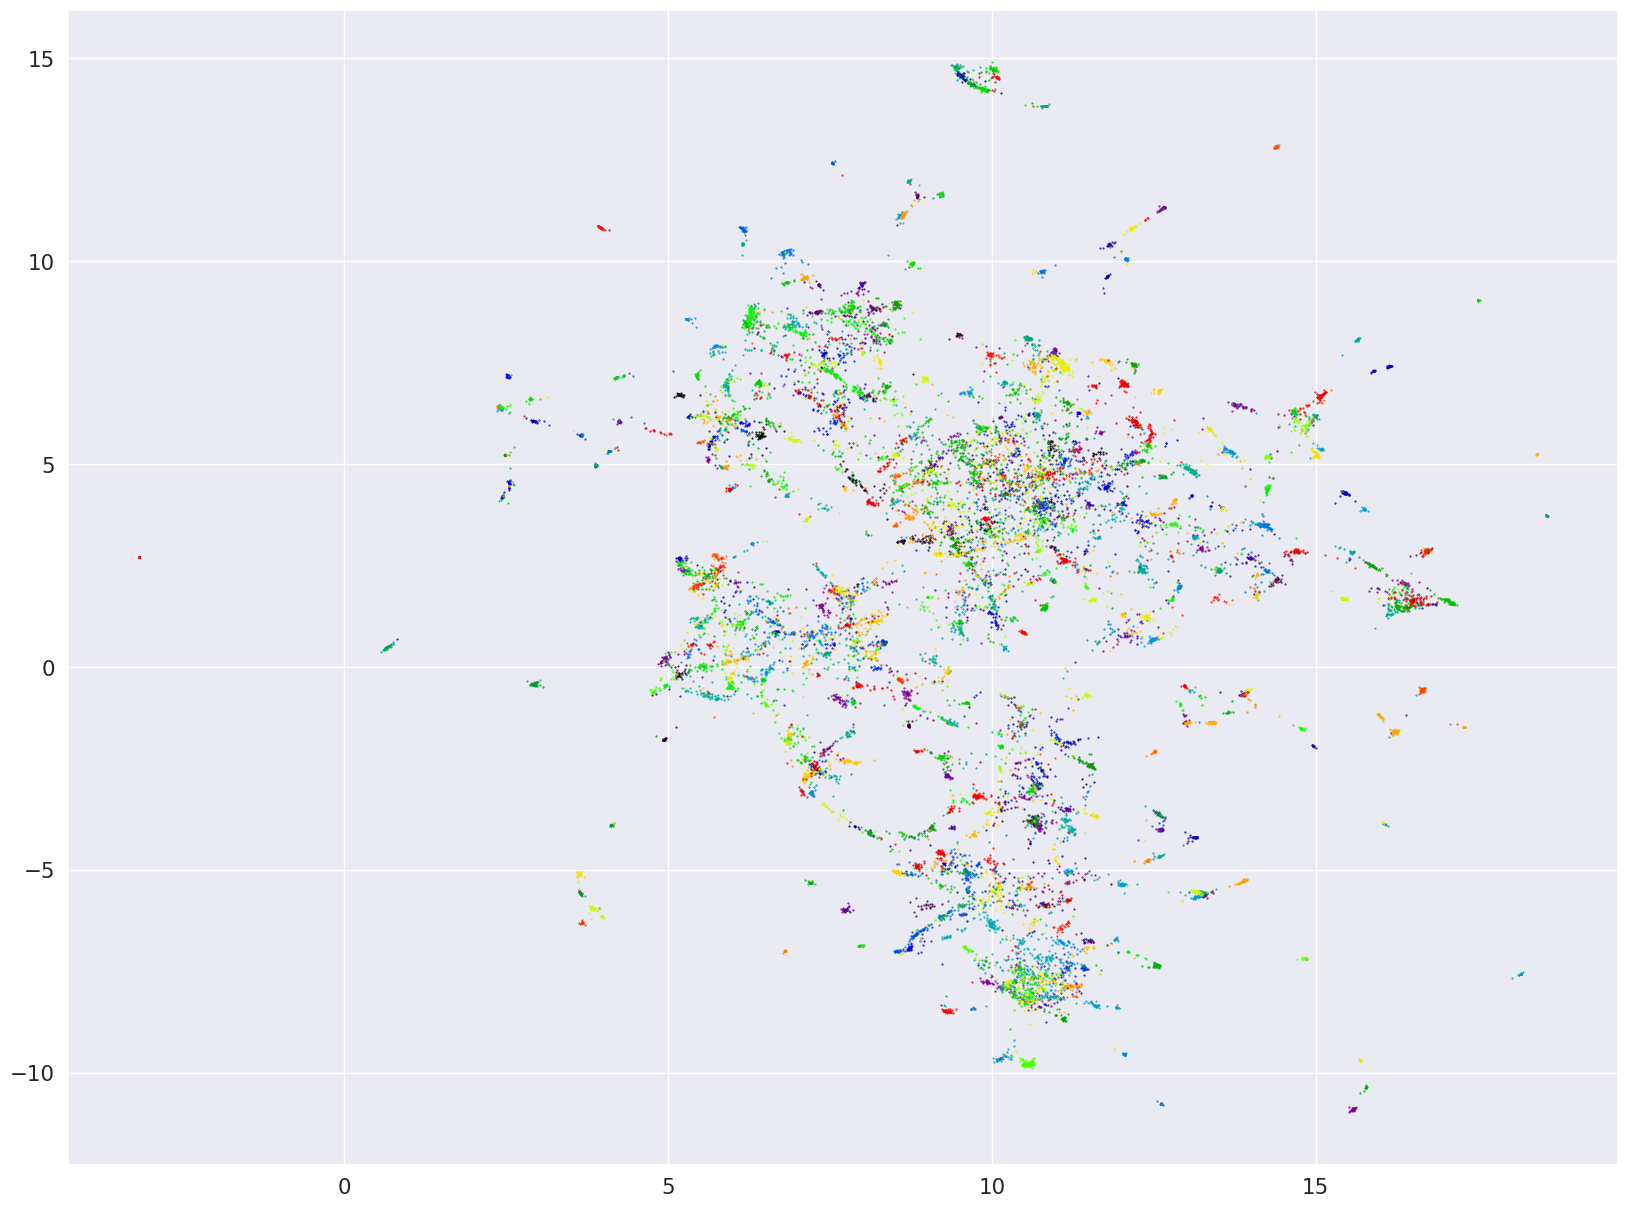

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.39071876094028407
INFO:PML:TRAINING EPOCH 12
total_loss=0.84430: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:03<00:00,  1.70it/s]
INFO:PML:Evaluating epoch 12
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.80it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


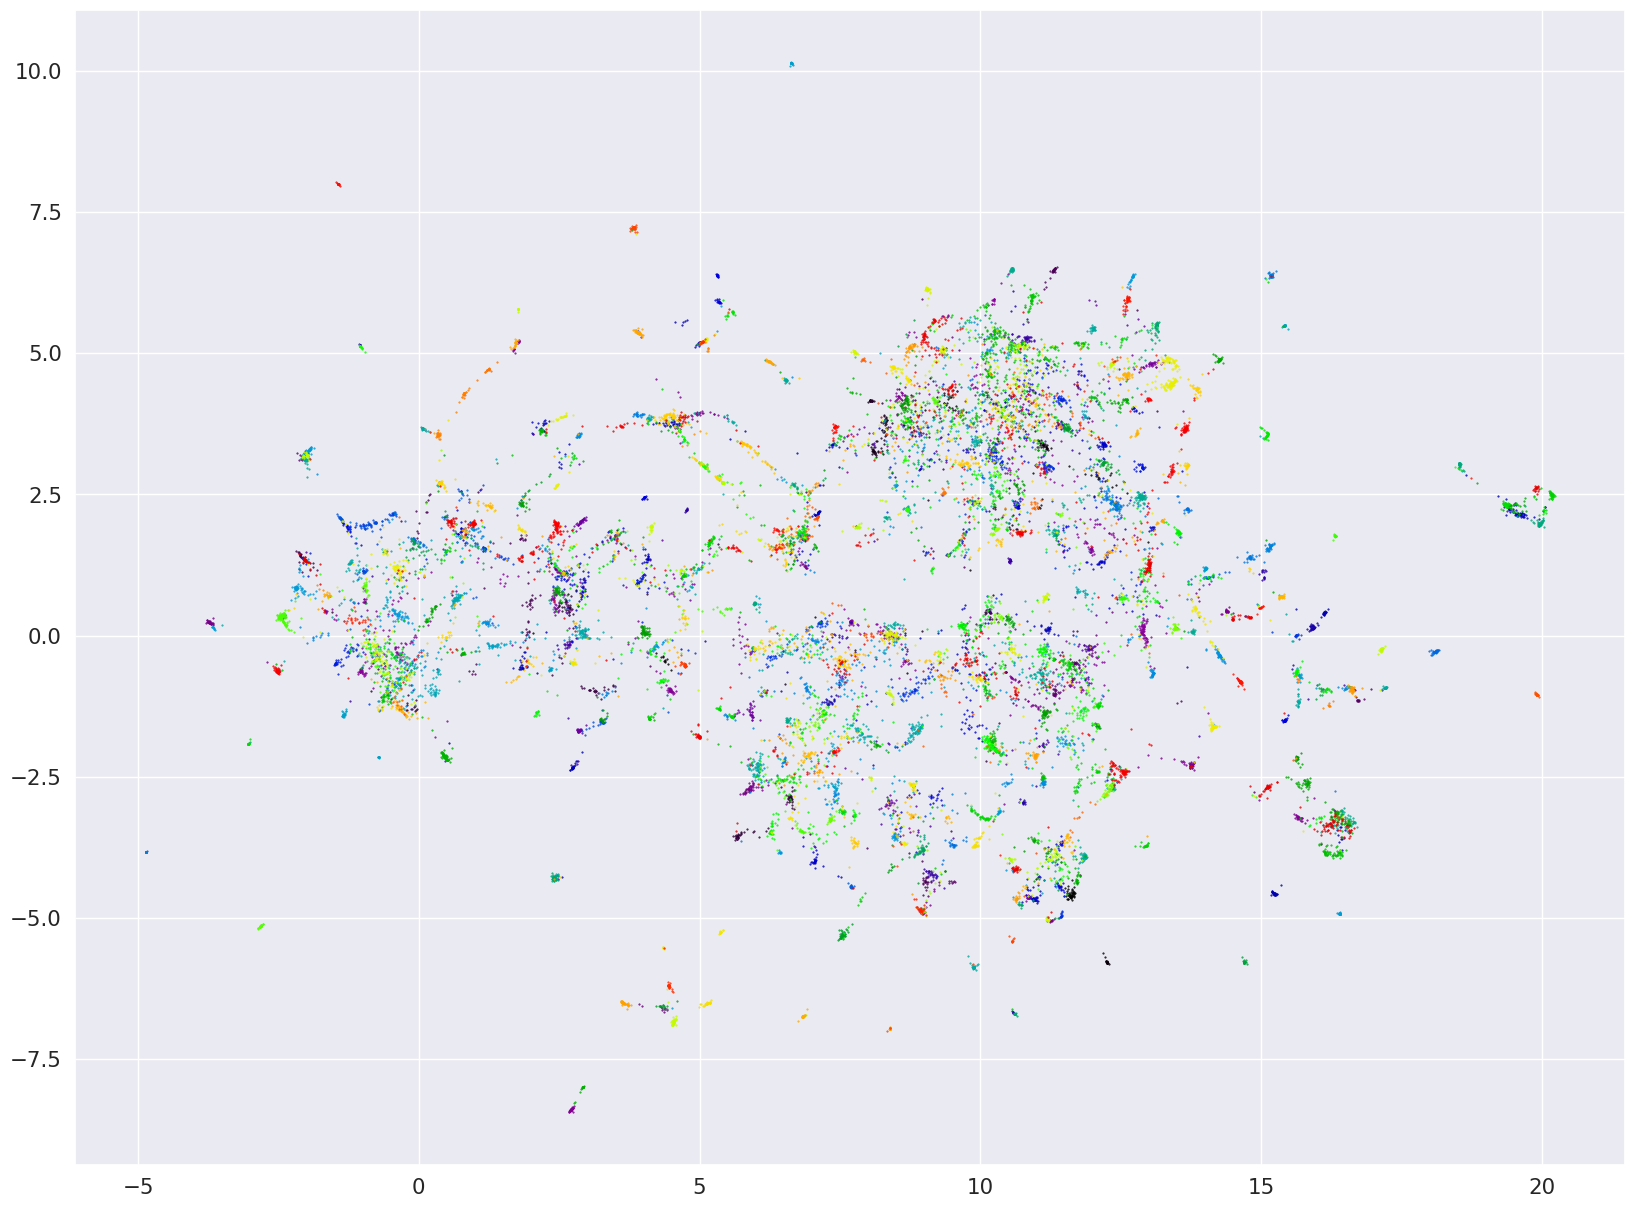

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:TRAINING EPOCH 13
total_loss=0.77106: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:00<00:00,  1.71it/s]
INFO:PML:Evaluating epoch 13
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.80it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


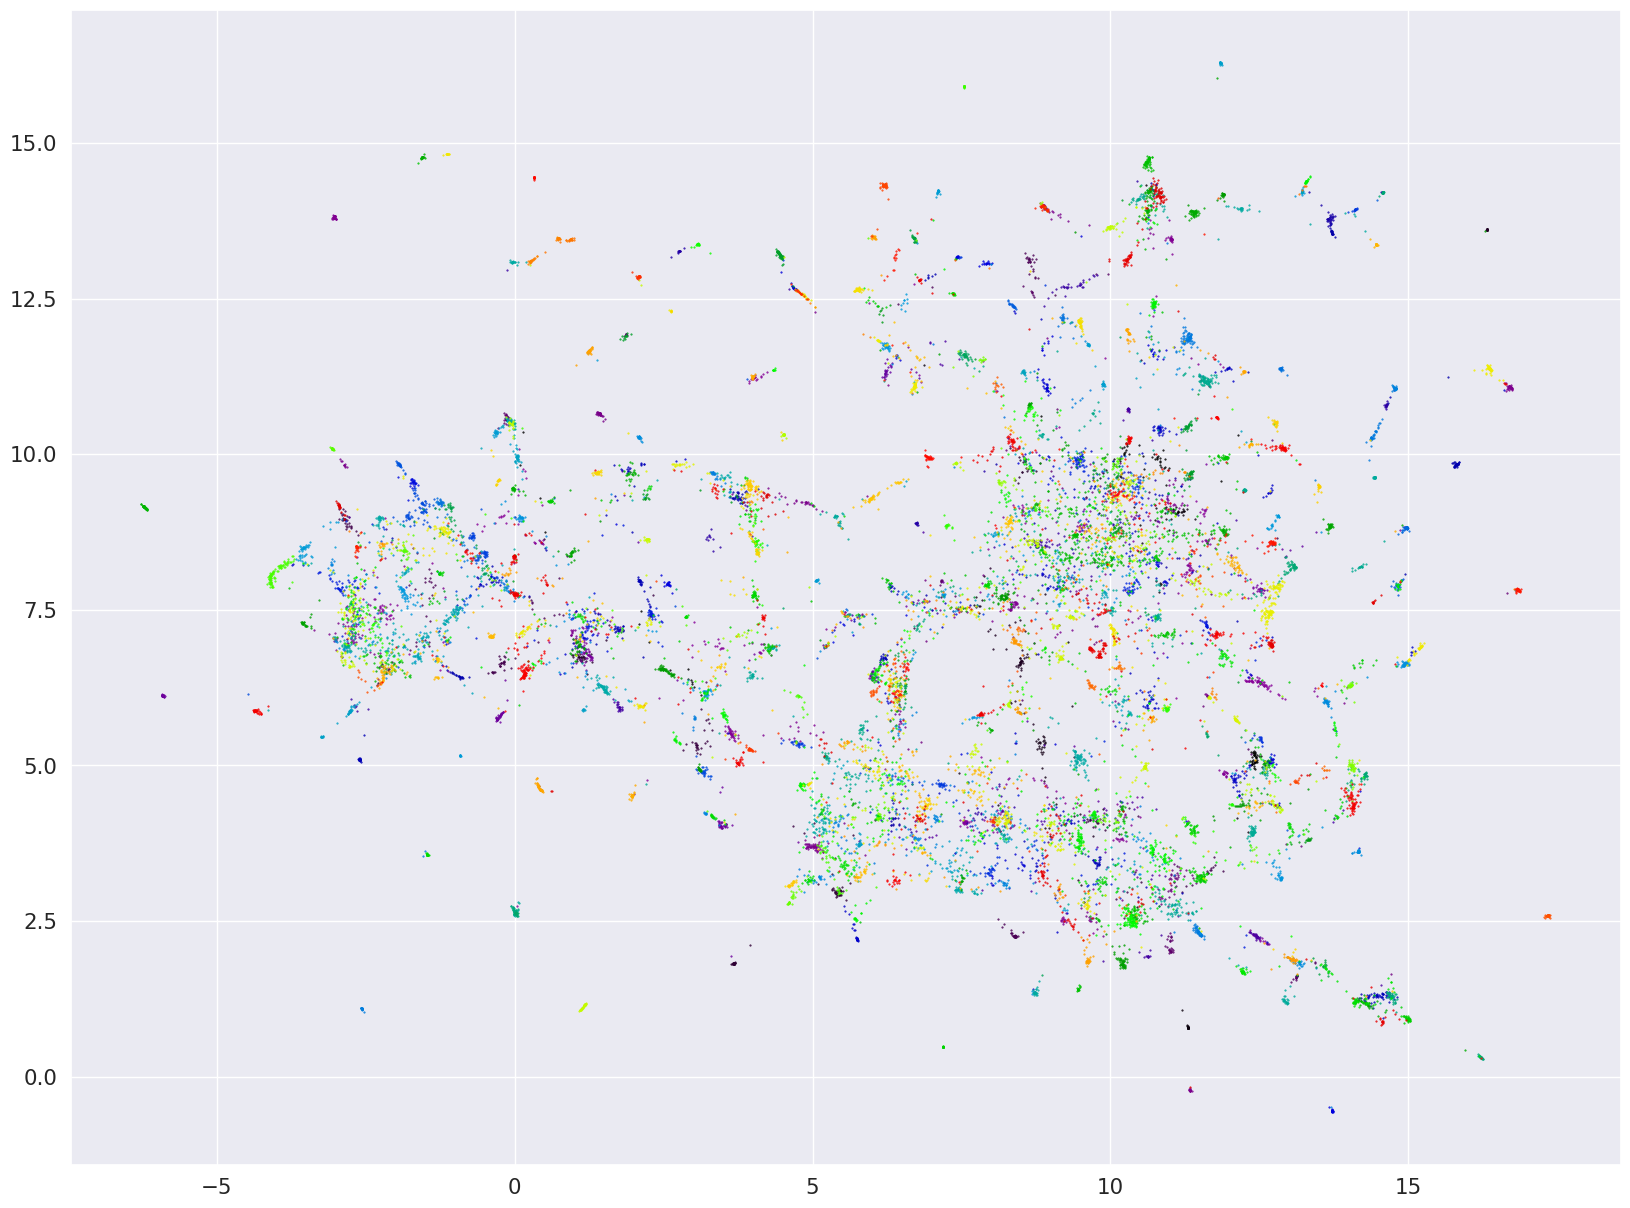

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.397702747396839
INFO:PML:TRAINING EPOCH 14
total_loss=1.14268: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:00<00:00,  1.71it/s]
INFO:PML:Evaluating epoch 14
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:41<00:00,  5.54it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


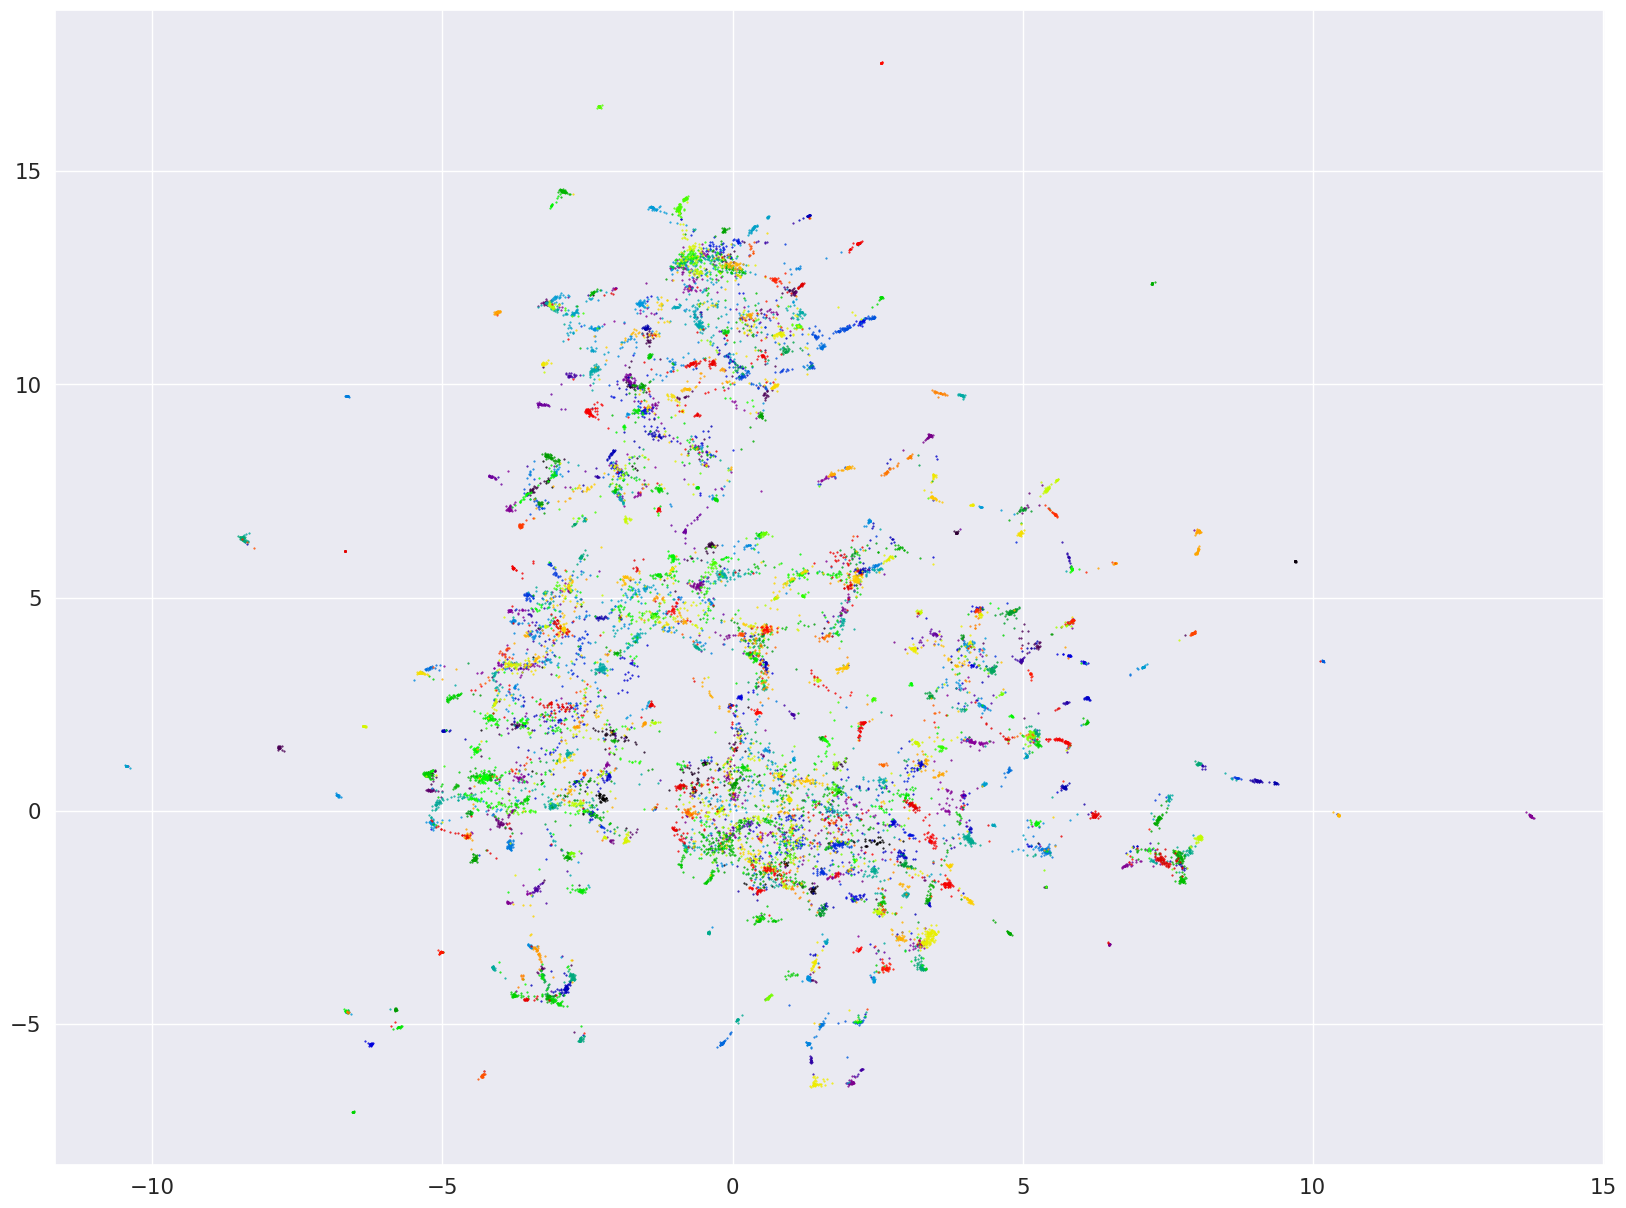

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.4072670136189062
INFO:PML:TRAINING EPOCH 15
total_loss=0.67702: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:11<00:00,  1.68it/s]
INFO:PML:Evaluating epoch 15
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:38<00:00,  5.73it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


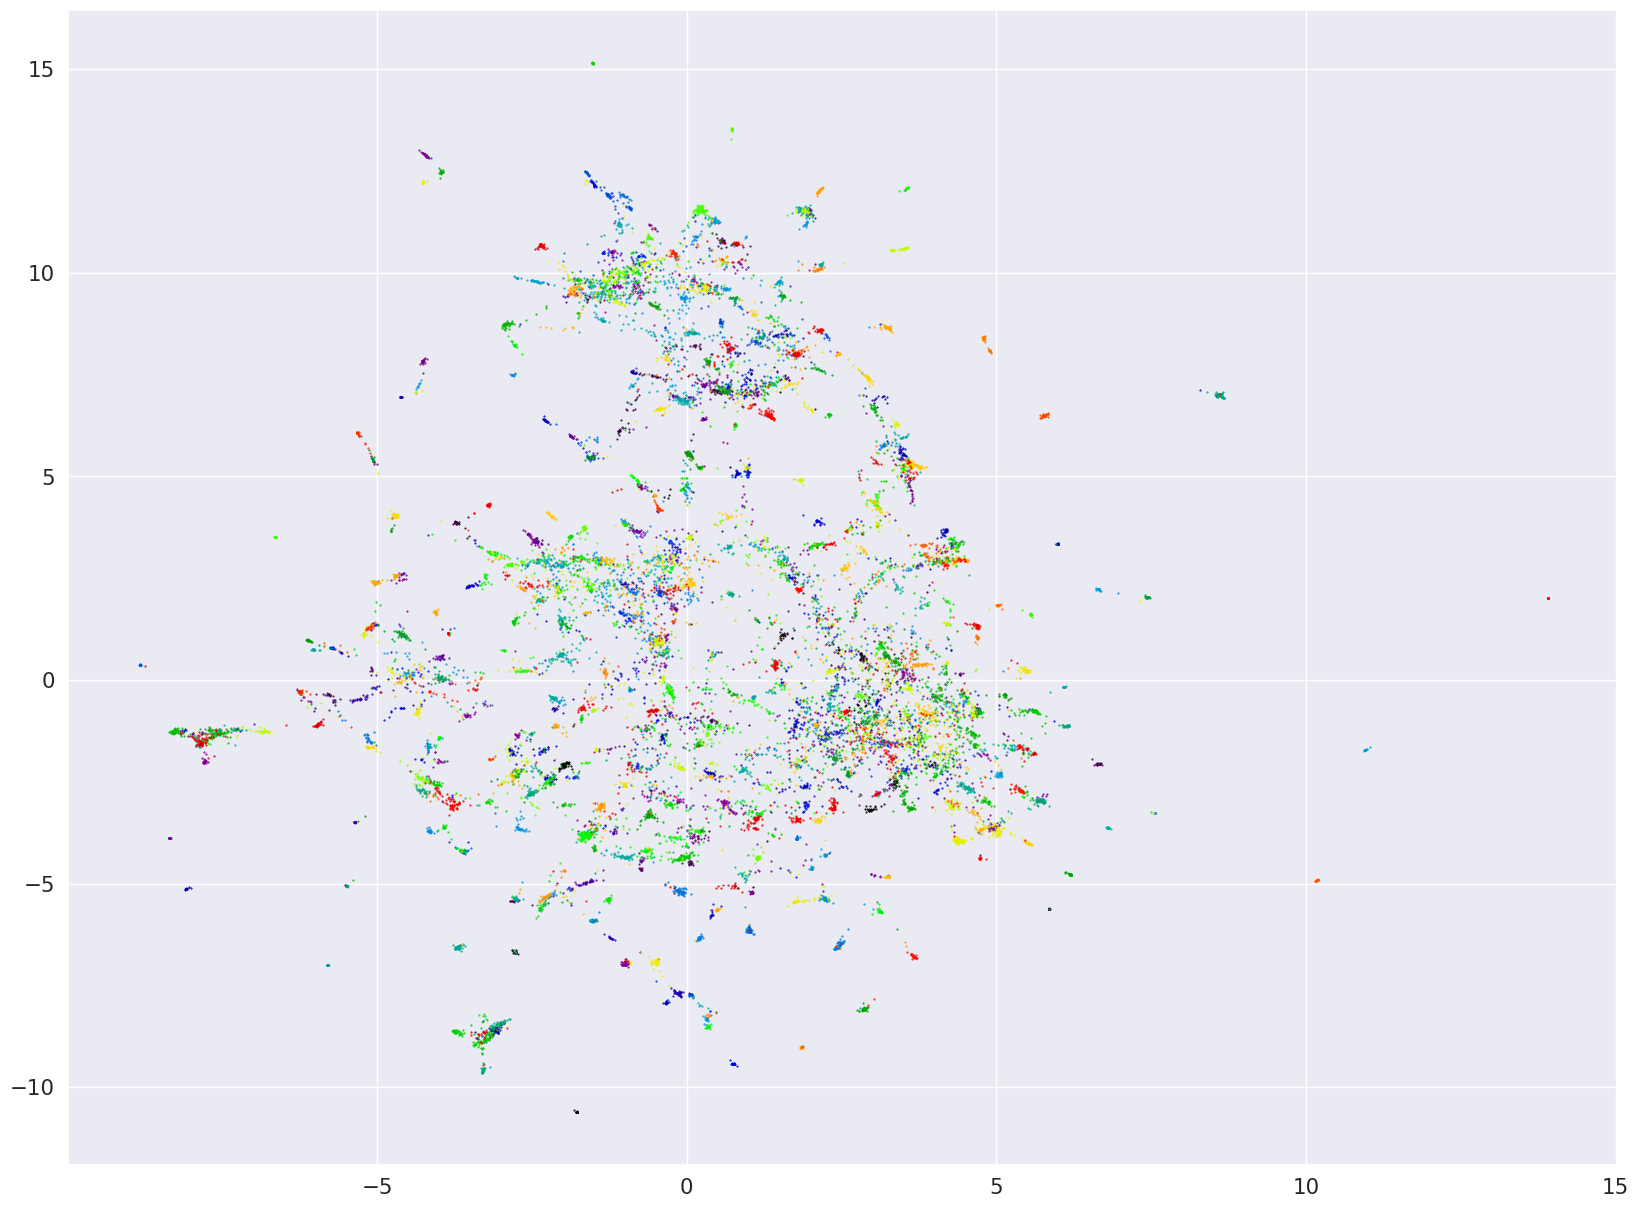

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:TRAINING EPOCH 16
total_loss=0.81102: 100%|███████████████████████████████████████████████████████████| 1028/1028 [10:03<00:00,  1.70it/s]
INFO:PML:Evaluating epoch 16
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:36<00:00,  5.80it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


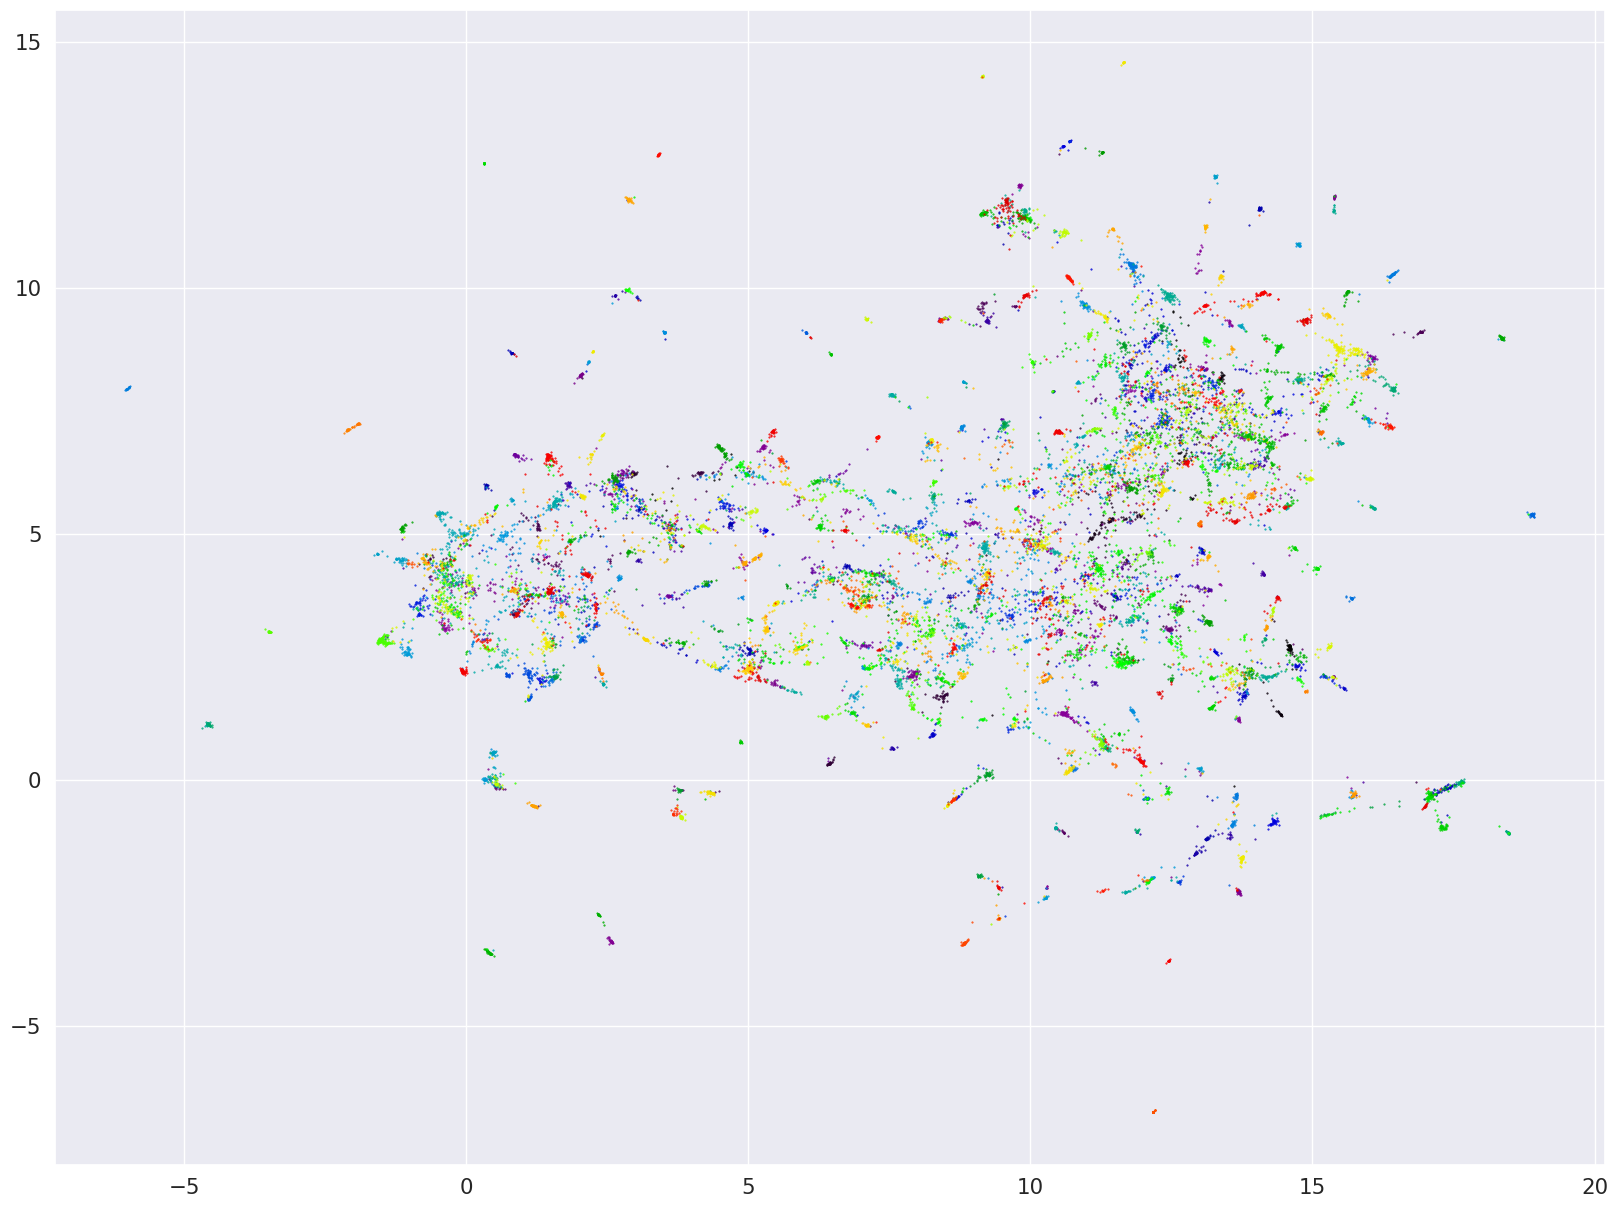

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:Validation accuracy has plateaued. Exiting.


In [14]:
trainer.train(num_epochs=num_epochs)

In [ ]:
v6 res101 0.0001lr - no aug - same normalizition